# Trabajo Práctico N° 3

El objetivo de este trabajo práctico es implementar modelos de regresión categórica que nos permita resolver problemas de clasificación.

Para ello utilizaremos un dataset "propio", es decir, fue seleccionado por los integrantes de nuestro.

El dataset elegido fue una base de datos de estudios de Resonancia Magnética correspondiente a clientes de la empresa Canon Medical Systems Argentina.

Estos datos describen los estudios realizados por el resonador magnético indicando distintas características del mismo como:

- Fecha/Hora
- Duración
- Región Anatómica a la que corresponde
- Bobina de Radiofrecuencia Utilizada
- Tiempo de Respuesta (RT)
- TIempo de Estimulación (RE)
- Campo de Visión (FOV)

La variable target elegida es la de **Región Anatómica**.

La lógica implentada es que según la región del cuerpo que se quiere estudiar (cabeza, tórax, muñeca, rodilla) van a variar distintos parámetros correspondientes al estudio como: tiempo de duración del mismo, tipo de bobina utilizado, campo de visión, plano de reconstrucción, tamaño de píxeles de la matriz de reconstrucción, etc.


## 0- Importación de Librerias 

In [1]:
#Importacion de librerias/módulos
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid")

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
pd.set_option("display.max_columns", None)


## 1- Lectura/Análisis Inicial de los datos

### Leemos el dataset de un archivo .csv

In [2]:
#Establezco la dirección del archivo
file_location='Data\datos_TP3'

#Leo el data set usando la librería pandas
# y se almacena en el objeto Dataframe llamado datos_crudos  
datos_crudos=pd.read_csv(file_location, index_col=0)


### Visualizamos los primeros registros del mismo. Desplegando todas las columnas

In [3]:
#Configuramos para que muestre todas las columnas
pd.set_option('display.max_columns', None)

datos_crudos.sample(10)

,Study,No,Start,Scan ID,Mode,Scan Comment,Anatomy,PatientOrient,RcCoil,TxCoil,ContrastName,Plane,Sequence,Option,ScanMode,Time,TR,TE,FA,NS,ST,Gap,FOV,MTX,NAQ,BW,NoWrap,Options,Fltr,Gate,Coverages,Dynamic,SORS,FAT,MTC,Date,Site_ID,Site Name
77138,22423.8455,2,09:49,AX PDWI FatSAT,(A),AX PDWI FatSAT,Extremity,F:S,8KNEE,WB,NaN,Oth:Oth,FSE2D+15,NaN,(A),03:00,2762,30,90/180,26,4.0,0.8,17.0,224 x 272,1.0,140,PE,NaN,GA44,NaN,1,OFF,NaN,ON,OFF,2022-10-23,8631,Hospital Español de Mendoza
132535,42247.8380,0,13:35,Loc 2Axis,NaN,NaN,Extremity,F:S,0x47410069,WB,NaN,Oth:RL,FE_crt,SLT,NaN,00:24,44,5,25,6,10.0,5.0,45.0,128 x 256,1.0,244,PE,SLT,NL2,NaN,2,OFF,NaN,OFF,OFF,2022-10-11,8633,Sanatorio Juncal
3867,34711.8268,2,15:04,Loc CO M/S(A),(AC),Loc CO M/S(A),TL-Spine,H:S,OHB-A,WB,NaN,CO:RL,FE_crt,NaN,(AC),00:08,60,4,60,5,10.0,2.0,40.0,128 x 256,1.0,488,NaN,NaN,NL2,NaN,1,OFF,NaN,OFF,OFF,2022-08-26,8268,Clínica Modelo de Morón
123550,41484.8380,9,16:17,Shimming,(A),iAAS_Head_HEAD,Head,F:S,OHD-A,WB,NaN,AX:AP,FE_AAS,AAS,(A),00:13,200,4.8/9.6,70,15,5.0,12.5,32.9,64,1.0,488,NaN,AAS,NONE,NaN,1,OFF,NaN,OFF,OFF,2022-09-15,8633,Sanatorio Juncal
52498,40484.8113,5,16:11,T2WI,(A),AX T2WI,TL-Spine,H:S,OHB-A,WB,NaN,Oth:Oth,FSE2D+10,:fcSS,(A),02:59,5400,120,90/160,21,3.5,0.7,20.0,256,2.0,244,PE/RO,:fcSS,GA53,NaN,1,OFF,NaN,OFF,OFF,2022-10-03,8630,Clinica Pequeña Familia
132559,42249.8380,0,15:15,Locator AX/CO,NaN,NaN,Chest,H:P,0x47410074,WB,NaN,Oth:RL,FE_crt,SLT,NaN,00:16,55,4,60,10,8.0,2.0,45.0,128 x 256,1.0,244,NaN,SLT,GA01,NaN,2,OFF,NaN,OFF,OFF,2022-10-11,8633,Sanatorio Juncal
86627,29589.8193,8,16:48,SG STIR+,(A),SG STIR+,Head,H:S,OHD-A,WB,NaN,Oth:Oth,FSE2D+7.5,NaN,(A),03:44,3200,45,90/140,19,3.0,0.3,25.0 x 18.0,192 x 240,2.0,326,PE,NaN,GA42,NaN,2,OFF,NaN,OFF,OFF,2022-08-26,8632,IRSA Jujuy
62388,21202.8455,4,13:37,T1WI,(A),AX T1WI,Head,H:S,OHD-A,WB,NaN,Oth:Oth,SE15_opt,NaN,(A),03:00,699,15,70/180,26,5.0,1.0,23.0 x 26.0,256 x 320,1.0,122,NaN,NaN,GA42,NaN,1,OFF,NaN,OFF,OFF,2022-08-12,8631,Hospital Español de Mendoza
70669,21895.8455,9,18:57,PELVIS AX T1WI,(AB),PELVIS AX T1WI (BH),Pelvis,F:S,BODY,WB,NaN,Oth:Oth,FSE2D+7.5,NaN,(AB),01:15,420,15,90/160,40,5.0,1.0,30.0 x 40.0,224 x 352,1.0,326,NaN,NaN,GA42,NaN,5,OFF,NaN,OFF,OFF,2022-09-19,8631,Hospital Español de Mendoza
7075,34973.8268,2,22:18,AX Shimming,(A),AX Shimming,C-Spine,H:S,OHD-A,WB,NaN,AX:AP,FE_AAS,NaN,(A),00:26,200,4.8/9.6,70,15,8.0,6.0,25.0,64,1.0,488,PE/RO,NaN,NL4,NaN,1,OFF,NaN,OFF,OFF,2022-09-12,8268,Clínica Modelo de Morón


### Verificamos la calidad de columnas en cuanto valores nulos

In [4]:
#Ordenando de mayor a menor por porcentaje de valores nulos en cada columna
datos_crudos.isna().sum().sort_values(ascending=False)/datos_crudos.shape[0]*100

SORS             99.656729
Gate             99.349739
ContrastName     96.485659
Options          82.476435
Option           82.476435
NoWrap           45.239208
ScanMode          8.969001
Mode              8.969001
Gap               5.034641
Scan Comment      3.875753
Scan ID           0.004186
Anatomy           0.000000
Time              0.000000
PatientOrient     0.000000
RcCoil            0.000000
TxCoil            0.000000
Start             0.000000
Plane             0.000000
Sequence          0.000000
No                0.000000
Site Name         0.000000
FA                0.000000
TR                0.000000
TE                0.000000
Site_ID           0.000000
NS                0.000000
ST                0.000000
FOV               0.000000
MTX               0.000000
NAQ               0.000000
BW                0.000000
Fltr              0.000000
Coverages         0.000000
Dynamic           0.000000
FAT               0.000000
MTC               0.000000
Date              0.000000
S

### Removemos aquellas columnas que son redundantes y/o tiene altos valores de porcentajes nulos

In [4]:
# Drop Columnas redundantes y que tienen gran cantidad de Nans
datos=datos_crudos.drop(columns=["SORS", "Gate", "ContrastName", "Options", "Option", "NoWrap", "Site_ID", "Date","Site Name"])

### Ahora damos de la baja las filas donde haya valores nulos

In [5]:
# Drop filas con Nans restantes
datos.dropna(axis=0, inplace=True)

### Verificamos las posibles categorías de la variable target "Región Anatómica"

In [6]:
datos.Anatomy.value_counts(normalize=True)*100

Head         25.284632
TL-Spine     19.461063
Extremity    18.760876
Abdomen      10.523525
Shoulder      7.211515
Pelvis        6.895809
C-Spine       6.854378
Ankle         2.365721
Hand          1.392088
Chest         1.210620
???           0.039774
Name: Anatomy, dtype: float64

In [7]:
# Elimino las filas con target "???""
datos = datos[datos['Anatomy'] != "???"]

## Descripción de Columnas Features:

- PatientOrient: Orientación del paciente dentro del gantry.
- RcCoil: Bobina de Radiofrecuencia.
- TxCoil: Bobina de Transmisión.
- Plane: Plano del estudio.
- Sequence: Tipo de secuencia del estudio.
- Time: Tiempo de duración en minutos de la secuencia.
- TR(Repetition Time)
- TE(Echo Time)
- FA
- NS
- ST
- Gap
- FOV
- MTX
- NAQ


## 3-Implementación de Modelos

### Definimos la matriz de features y el vector target

In [8]:
#Matriz de Features
X = datos[['PatientOrient','RcCoil','TxCoil','Plane','Sequence','Time','TR','TE','FA','NS','ST','Gap','FOV','MTX','NAQ']]

#Vector Target
y = datos.Anatomy



In [29]:
categorical = X.select_dtypes("object").columns

### Separamos los datos en Train y Test

In [9]:
#Train y split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1, stratify=y)

### Implementamos Dummies para las variables categóricas

In [10]:
# Creo Dummies

from sklearn.preprocessing import OneHotEncoder

onehot = OneHotEncoder(handle_unknown='ignore')

# Aplicamos OneHotEncoder al conjunto de entrenamiento
X_train = onehot.fit_transform(X_train)

# Aplicamos OneHotEncoder al conjunto de prueba
X_test = onehot.transform(X_test)

In [11]:
# Scalar
from sklearn import preprocessing

scaler = preprocessing.StandardScaler(with_mean=False)
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

### Definimos una función que evalue los modelos aplicando distintas métricas:

In [12]:
# Funcion para Scores

resultados_fin = pd.DataFrame()

def evaluacion(y_test, y_pred, model=""):
    # Crear diccionario para almacenar los resultados
    resultados = {}

      # Calcular sensibilidad
    sensibilidad = metrics.recall_score(y_test, y_pred, average='macro')
    resultados['Sensibilidad'] = sensibilidad

    # Calcular accuracy
    accuracy = metrics.accuracy_score(y_test, y_pred)
    resultados['Accuracy'] = accuracy

    # Calcular precision
    precision = metrics.precision_score(y_test, y_pred, average='macro')
    resultados['Precision'] = precision

    # Graficar matrix de confusion con heatmap
    cm = metrics.confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", xticklabels=np.unique(y_test).tolist(), yticklabels=np.unique(y_pred).tolist())
    plt.title('Matrix de Confusion')
    plt.ylabel('Valor Real')
    plt.xlabel('Valor Predicho')
    plt.show()

    resultado_df = pd.DataFrame.from_dict(resultados, orient='index', columns=[model])
    resultados_fin= resultado_df 
    return resultados_fin

## 3.1 - Regresión Logística

In [13]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(max_iter=1000)

lr.fit(X_train, y_train)

ypred_lr = lr.predict(X_test)


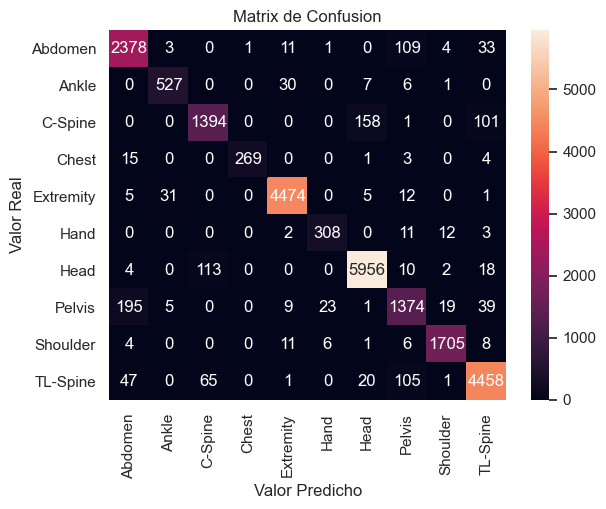

,Logistic_Regression
Sensibilidad,0.925752
Accuracy,0.946782
Precision,0.935055


In [14]:
evaluacion(y_test, ypred_lr, model="Logistic_Regression")

## 3.2 - Naive Bayes

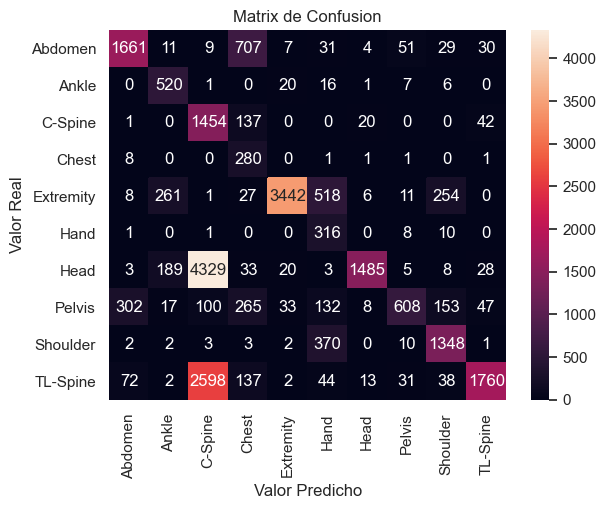

,Naive_Bayes
Sensibilidad,0.686070
Accuracy,0.533593
Precision,0.631873


In [15]:
from sklearn.naive_bayes import GaussianNB

gnb = GaussianNB()

gnb.fit(X_train.toarray(), y_train)

ypred_gnb = gnb.predict(X_test.toarray())
evaluacion(y_test, ypred_gnb, model="Naive_Bayes")

## 3.3 - KNN - n arbitrario manual

In [15]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=5)

# Hyperparametros
#parameters_knn = {"n_neighbors" : list(range(1, 3))}

'''clf_knn = GridSearchCV(knn, 
                   param_grid = parameters_knn, 
                   refit = True, 
                   cv = 3,
                   verbose=1,
                   n_jobs = -1) '''
                   

# Fit el modelo ya seleccionado
knn.fit(X_train, y_train)

KNeighborsClassifier()

In [16]:
ypred_knn = knn.predict(X_test)

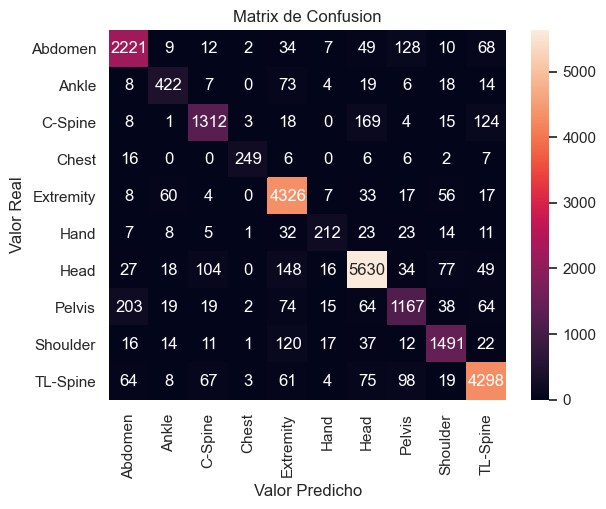

,KNN
Sensibilidad,0.824063
Accuracy,0.883989
Precision,0.853718


In [17]:
evaluacion(y_test, ypred_knn, model="KNN")

## 3.3.1 - KNN RandomSearch

In [19]:
from sklearn.model_selection import RandomizedSearchCV

knn2 = KNeighborsClassifier()

# Hyperparametros
parameters_knn2 = {"n_neighbors" : list(range(1, 15))}

random = RandomizedSearchCV(knn2, parameters_knn2, n_iter=2, cv=3, scoring='accuracy',random_state=10)


'''clf_knn = GridSearchCV(knn, 
                   param_grid = parameters_knn, 
                   refit = True, 
                   cv = 3,
                   verbose=1,
                   n_jobs = -1) '''
                   

# Fit el modelo ya seleccionado
random.fit(X_train, y_train)

KeyboardInterrupt: 